In [3]:
import pandas as pd
import os

ROOT_DIR = os.path.dirname(os.path.abspath(""))
assert ROOT_DIR.endswith("Synthesis-Project-1"),\
	"Root directory is not Synthesis-Project-1. Ensure your python file is in the 'src/' directory of the repository"

file = os.path.join(ROOT_DIR, "data/sitges_access_clean.csv")
df = pd.read_csv(file)

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from skipgram import *
import scipy

In [4]:
class PVModel(nn.Module):
	def __init__(self, vector_dim, hidden_dim, n_layers, dropout_prob=0.5):
		super(PVModel, self).__init__()
		self.hidden_dim = hidden_dim
		self.n_layers = n_layers
		
		self.lstm = nn.LSTM(vector_dim, hidden_dim, n_layers, batch_first=True)
		self.dropout = nn.Dropout(dropout_prob)
		self.fc1 = nn.Linear(hidden_dim, 256)
		self.bn1 = nn.BatchNorm1d(256)
		self.fc2 = nn.Linear(256, vector_dim)
		
	def forward(self, x, hc):
		out, hc = self.lstm(x, hc)
		out = self.dropout(out[:, -1, :])
		out = self.fc1(out)
		
		if out.size(0) > 1:
			out = self.bn1(out)
		
		out = torch.relu(out)
		out = self.fc2(out)
		return out, hc
	
	def init_hidden(self, batch_size, device='cpu'):
		hidden_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
		cell_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
		return hidden_state, cell_state
	
	def apply_weight_init(self):
		for m in self.modules():
			if isinstance(m, nn.LSTM):
				for name, param in m.named_parameters():
					if 'weight_ih' in name:
						nn.init.xavier_uniform_(param.data)
					elif 'weight_hh' in name:
						nn.init.orthogonal_(param.data)
					elif 'bias' in name:
						param.data.fill_(0)
			elif isinstance(m, nn.Linear):
				nn.init.xavier_uniform_(m.weight.data)
				if m.bias is not None:
					m.bias.data.fill_(0)
	
model = PVModel(15, 128, 2)
test_input = torch.randn(1, 10, 15) # batch_size, seq_len, vector_dim
state = model.init_hidden(1) # batch_size
output, state = model(test_input, state)
print(output.shape)

torch.Size([1, 15])


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

total_params = count_parameters(model)
print(f"Total parameters in the model: {total_params}")

Total parameters in the model: 243727


In [6]:
# sort by group and index
df_sorted = df.copy()
df_sorted["index"] = df_sorted.index
df_sorted = df_sorted.sort_values(["group", "index"])
df_sorted = df_sorted.drop(columns=["index"])
df_sorted = df_sorted.reset_index(drop=True)
df_sorted.head()

,URL,bytes,referer,user-agent,level,group,elapsed,IP_oct0,IP_oct1,IP_oct2,...,petition_-,petition_GET,petition_HEAD,petition_POST,petition_other,status_1,status_2,status_3,status_4,status_5
0,/en/ HTTP/2.0,0.705313,-,Mozilla/5.0 (iPhone; CPU iPhone OS 17_0_3 like...,0.0,0,0.000000,-2.241572,-0.042445,-1.449457,...,0,1,0,0,0,False,1,0,0,0
1,/plantilles/turisme/css/estils-mw900.css?v=8 H...,-0.286473,https://www.sitgesanytime.com/en/,Mozilla/5.0 (iPhone; CPU iPhone OS 17_0_3 like...,0.0,0,0.693147,-2.241572,-0.042445,-1.449457,...,0,1,0,0,0,False,1,0,0,0
2,/plantilles/turisme/css/animate.css HTTP/2.0,0.148994,https://www.sitgesanytime.com/en/,Mozilla/5.0 (iPhone; CPU iPhone OS 17_0_3 like...,0.0,0,0.000000,-2.241572,-0.042445,-1.449457,...,0,1,0,0,0,False,1,0,0,0
3,/plantilles/turisme/css/font/Intro-Black-Alt.w...,1.163816,https://www.sitgesanytime.com/en/,Mozilla/5.0 (iPhone; CPU iPhone OS 17_0_3 like...,0.0,0,0.000000,-2.241572,-0.042445,-1.449457,...,0,1,0,0,0,False,1,0,0,0
4,/comu/js/jquery-ui-1.13.1/jquery-ui.min.js HTT...,1.772615,https://www.sitgesanytime.com/en/,Mozilla/5.0 (iPhone; CPU iPhone OS 17_0_3 like...,0.0,0,0.000000,-2.241572,-0.042445,-1.449457,...,0,1,0,0,0,False,1,0,0,0


In [7]:
# normalize column "elapsed"
df_sorted["elapsed"] = (df_sorted["elapsed"] - df_sorted["elapsed"].mean()) / df_sorted["elapsed"].std()

In [8]:
class GroupSequenceDataset(Dataset):
	
	def __init__(self, data, seq_len=15):
		self.df = data
		self.seq_len = seq_len
		self.gs = self.df["group"].unique()
		self.groups_idx = {g: self.df[self.df["group"] == g].index.to_numpy() for g in self.gs}
		self.groups = torch.tensor(self.df["group"].to_numpy(), dtype=torch.int32)
		self.pos_in_group = torch.empty(len(self.df), dtype=torch.int32)
		for group in self.groups_idx.values():
			self.pos_in_group[group] = torch.arange(len(group), dtype=torch.int32)

		# extract embeddings
		print("Loading embeddings...")
		embeddings_url = load_embeddings(os.path.join(ROOT_DIR, "models", "embeddings-url.pt"))
		idx2word_url = load_idx2word(os.path.join(ROOT_DIR, "models", "idx2word-url.json"))
		tokenizer_url = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-url")
		embeddings_referer = load_embeddings(os.path.join(ROOT_DIR, "models/embeddings-referer.pt"))
		idx2word_referer = load_idx2word(os.path.join(ROOT_DIR, "models/idx2word-referer.json"))
		tokenizer_referer = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-referer")
		embeddings_useragent = load_embeddings(os.path.join(ROOT_DIR, "models/embeddings-useragent.pt"))
		idx2word_useragent = load_idx2word(os.path.join(ROOT_DIR, "models/idx2word-useragent.json"))
		tokenizer_useragent = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-useragent")

		print("Extracting embeddings...")
		url_embeddings = extract_embeddings(
			sequence = self.df["URL"],
			embeddings = embeddings_url,
			idx2word = idx2word_url,
			tokenizer = tokenizer_url
		)
		referers_embeddings = extract_embeddings(
			sequence = self.df["referer"],
			embeddings = embeddings_referer,
			idx2word = idx2word_referer,
			tokenizer = tokenizer_referer
		)
		useragents_embeddings = extract_embeddings(
			sequence = self.df["user-agent"],
			embeddings = embeddings_useragent,
			idx2word = idx2word_useragent,
			tokenizer = tokenizer_useragent
		)

		print("Preparing dataset...")
		self.df = self.df.drop(columns=["URL", "referer", "user-agent", "level", "group"])
		self.df = self.df.reindex(columns=[
			"bytes", "elapsed", "IP_oct0", "IP_oct1", "IP_oct2", "IP_oct3", "month_sin",
			"month_cos", "day_sin", "day_cos", "weekday_sin", "weekday_cos",
			"hour_sin", "hour_cos", "minute_sin", "minute_cos", "petition_-",
			"petition_GET", "petition_HEAD", "petition_POST", "petition_other",
			"status_1", "status_2", "status_3", "status_4", "status_5"
		])
		self.df = self.df.astype(np.float32)
		self.pv_vectors = torch.empty(
			(len(self.df), self.df.shape[1] + url_embeddings[0].shape[1] + referers_embeddings[0].shape[1] + useragents_embeddings[0].shape[1]), dtype=torch.float32)
		for i in tqdm(range(len(self.df))):
			self.pv_vectors[i, :self.df.shape[1]] = torch.from_numpy(self.df.iloc[i].values)
			self.pv_vectors[i, self.df.shape[1]:] = torch.cat((url_embeddings[i].mean(0), referers_embeddings[i].mean(0), useragents_embeddings[i].mean(0)))

		means = torch.mean(self.pv_vectors, dim=0)
		stds = torch.std(self.pv_vectors, dim=0)+1e-6
		self.dist = torch.distributions.normal.Normal(means, stds)

		del self.df, url_embeddings, referers_embeddings, useragents_embeddings
		del embeddings_url, embeddings_referer, embeddings_useragent

	def __len__(self):
		return len(self.pv_vectors)
	
	def get_group(self, idx):
		return self.pv_vectors[self.groups_idx[self.groups[idx].item()]]

	def __getitem__(self, idx):
		group = self.get_group(idx)
		pos_in_group = self.pos_in_group[idx]

		# Truncate or pad the sequence to seq_len
		if pos_in_group >= self.seq_len:
			x = group[pos_in_group - self.seq_len:pos_in_group]
		else:
			padding = torch.zeros((self.seq_len - pos_in_group, group.shape[1]), dtype=torch.float32)
			# padding = self.dist.sample((self.seq_len - pos_in_group,)).squeeze(1)
			x = torch.cat((padding, group[:pos_in_group]), dim=0)
			
		y = group[pos_in_group]
		return x, y

In [9]:
class PVAnomalyDetectionModel():
	def __init__(self, vector_dim, hidden_dim, n_layers, device, lr=1e-3):
		self.model = PVModel(vector_dim, hidden_dim, n_layers).to(device)
		self.model.apply_weight_init()
		self.loss_fn = nn.MSELoss()
		self._loss_fn = nn.MSELoss(reduction='none')
		self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
		self.vector_dim = vector_dim
		self.hidden_dim = hidden_dim
		self.n_layers = n_layers
		self.device = device
		self.iqr_interval = (0, 0)
	
	def forward(self, x, seq_norm=True):
		if seq_norm:
			mean = x.mean(dim=1, keepdim=True)
			std = x.std(dim=1, keepdim=True)
			x = (x - mean) / (std + 1e-6)
		x = x.to(self.device)
		hc = self.model.init_hidden(x.size(0))
		hc = (hc[0].to(self.device), hc[1].to(self.device))
		out, hc = self.model(x, hc)
		return out

	def train(self, train_loader, n_epochs, seq_norm=True):
		losses = []
		self.model.train()
		for epoch in range(n_epochs):
			for i, (x, y) in enumerate(train_loader):
				self.optimizer.zero_grad()
				out = self.forward(x, seq_norm)
				loss = self.loss_fn(out, y.to(self.device))
				loss.backward()
				self.optimizer.step()
				losses.append(loss.item())
				print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item()}", end="\r")
		return losses
	
	def predict(self, x, seq_norm=True):
		self.model.eval()
		with torch.no_grad():
			out = self.forward(x, seq_norm)
			out = out.detach()
		return out
	
	def compute_iqr_interval(self, val_loader, seq_norm=True, q1=0.25, q2=0.75, k=1.5):
		self.model.eval()
		with torch.no_grad():
			all_errors = []
			for i, (x, y) in tqdm(enumerate(val_loader), total=len(val_loader)):
				pred = self.predict(x, seq_norm).to(self.device)
				y = y.to(self.device)
				loss = self.loss_fn(pred, y)
				all_errors.append(loss.item())
			all_errors = torch.tensor(all_errors)
		q1 = torch.quantile(all_errors, q1)
		q2 = torch.quantile(all_errors, q2)
		iqr = q2 - q1
		self.iqr_interval = (q1 - k * iqr, q2 + k * iqr)

	def detect(self, sequences, vecs, seq_norm=True, return_probs=False):
		self.model.eval()
		with torch.no_grad():
			preds = self.predict(sequences, seq_norm).to(self.device)
			losses = self._loss_fn(preds, vecs.to(self.device))
			losses = losses.mean(dim=1)
			iqr_interval = torch.tensor(self.iqr_interval).to(self.device)
			anomalies = losses > iqr_interval[1]
			if return_probs:
				distances = losses - iqr_interval[1]
				probs = torch.sigmoid(distances)
				return probs
		return anomalies
	
	def save(self, path):
		torch.save({
			"model_state_dict": self.model.state_dict(),
			"iqr_interval": self.iqr_interval,
			"vector_dim": self.model.lstm.input_size,
			"hidden_dim": self.model.lstm.hidden_size,
			"n_layers": self.model.lstm.num_layers
		}, path)

def load_model(path, device):
	checkpoint = torch.load(path)
	model = PVAnomalyDetectionModel(
		vector_dim=checkpoint["vector_dim"],
		hidden_dim=checkpoint["hidden_dim"],
		n_layers=checkpoint["n_layers"],
		device=device
	)
	model.model.load_state_dict(checkpoint["model_state_dict"])
	model.iqr_interval = checkpoint["iqr_interval"]
	return model

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def foo(model, loader, interval):
	model.model.eval()
	gt = df_sorted["level"][interval[0]: interval[1]].to_numpy()
	preds_list = []
	for x, y in tqdm(loader, total=len(loader)):
		batch_preds = model.detect(x, y, seq_norm=False)
		preds_list.append(batch_preds)
	preds = torch.cat(preds_list).to("cpu")
	total_anomalies = preds.sum().item()
	total_sequences = len(preds)
	print(f"{total_anomalies} / {total_sequences}")
	print(f"Accuracy: {(torch.tensor(gt) == preds).sum().item() / len(gt)}")
	cm = confusion_matrix(gt.astype(bool), preds.numpy())#, normalize="pred")
	sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues")
	plt.xlabel("Predicted")
	plt.ylabel("True")
	plt.show()

def bar(model, set, interval, iqr_interval):
	model.model.eval()
	foo_loss = []
	foo_pos = []
	levels = df_sorted[interval[0]:interval[1]]["level"].to_numpy()
	for i in tqdm(range(len(set)), total=len(set)):
		x, y = set[i]
		x = x.unsqueeze(0)
		y = y.unsqueeze(0)
		pred = model.predict(x, seq_norm=False)
		loss = model.loss_fn(pred, y.to(device))
		foo_loss.append(loss.item())
		foo_pos.append(set.pos_in_group[i].item())
	foo_loss = np.array(foo_loss)
	foo_pos = np.array(foo_pos)
	crosses = levels > 0
	circles = ~crosses
	red = foo_loss > iqr_interval[1].numpy()
	blue = ~red
	plt.scatter(foo_pos[circles & red], foo_loss[circles & red], c="r", marker="o", label="Normal Red", alpha=0.05)
	plt.scatter(foo_pos[circles & blue], foo_loss[circles & blue], c="b", marker="o", label="Normal Blue", alpha=0.05)
	plt.scatter(foo_pos[crosses & red], foo_loss[crosses & red], c="r", marker="x", label="Anomaly Red", alpha=0.05)
	plt.scatter(foo_pos[crosses & blue], foo_loss[crosses & blue], c="b", marker="x", label="Anomaly Blue", alpha=0.05)
	plt.xlabel("Position in group")
	plt.ylabel("Loss")
	plt.show()
	return foo_loss

In [11]:
training_set = GroupSequenceDataset(df_sorted[100000:200000].reset_index(drop=True), seq_len=15) # this subset has NO anomalies
validation_set = GroupSequenceDataset(df_sorted[200000:300000].reset_index(drop=True), seq_len=15) # this subset has NO anomalies
validation_set2 = GroupSequenceDataset(df_sorted[400000:500000].reset_index(drop=True), seq_len=15) # this subset HAS anomalies

Loading embeddings...
Extracting embeddings...


100%|██████████| 100000/100000 [00:09<00:00, 10446.41it/s]


Preparing dataset...


100%|██████████| 100000/100000 [00:10<00:00, 9149.06it/s]


Loading embeddings...
Extracting embeddings...


100%|██████████| 100000/100000 [00:08<00:00, 11341.11it/s]


Preparing dataset...


100%|██████████| 100000/100000 [00:10<00:00, 9102.60it/s]


Loading embeddings...
Extracting embeddings...


100%|██████████| 100000/100000 [00:09<00:00, 11083.88it/s]


Preparing dataset...


100%|██████████| 100000/100000 [00:11<00:00, 8723.92it/s]


In [12]:
train_loader = DataLoader(training_set, batch_size=256, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
val_loader2 = DataLoader(validation_set2, batch_size=256, shuffle=False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PVAnomalyDetectionModel(
	vector_dim=training_set.pv_vectors.shape[1],
	hidden_dim=128,
	n_layers=1,
	device=device,
	lr=1e-4
)

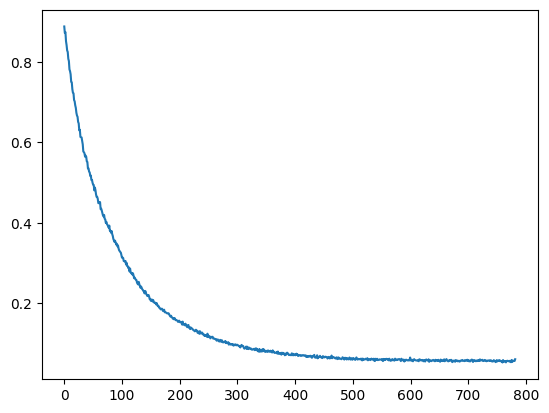

In [14]:
losses = model.train(train_loader, n_epochs=2, seq_norm=False)
plt.plot(losses);

In [15]:
model.compute_iqr_interval(val_loader, seq_norm=False, q1=0.1, q2=0.9, k=5)
model.iqr_interval

100%|██████████| 391/391 [00:26<00:00, 14.83it/s]


(tensor(0.1193), tensor(0.2538))

100%|██████████| 100000/100000 [01:42<00:00, 979.79it/s]


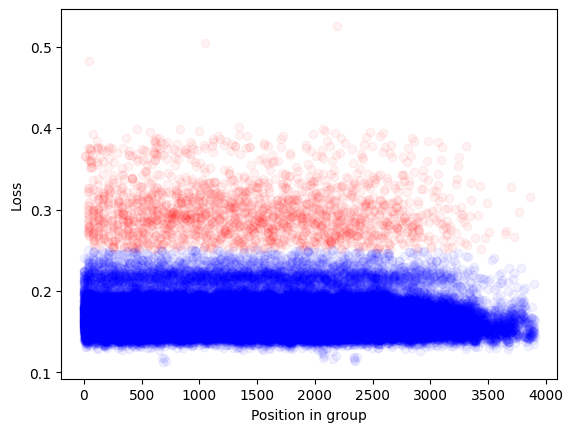

In [65]:
foo_loss = bar(model, validation_set, (200000, 300000), model.iqr_interval)

100%|██████████| 100000/100000 [00:59<00:00, 1669.01it/s]


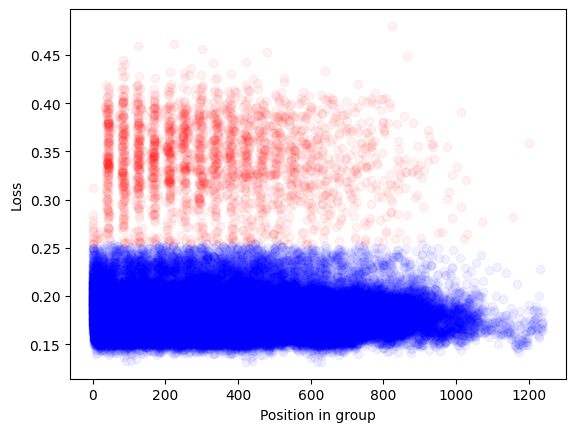

In [27]:
foo_loss = bar(model, validation_set2, (400000, 500000), model.iqr_interval)

In [ ]:
preds_list = []
probs_list = []
for x, y in tqdm(val_loader2, total=len(val_loader2)):
	batch_preds, batch_probs = model.detect(x, y, seq_norm=False, return_probs=True)
	preds_list.append(batch_preds)
	probs_list.append(batch_probs)
preds = torch.cat(preds_list).to("cpu")
probs = torch.cat(probs_list).to("cpu")

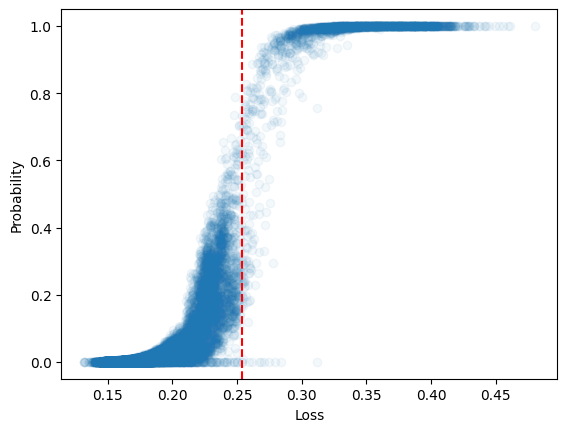

In [35]:
plt.scatter(foo_loss, probs, alpha=0.05)
plt.axvline(model.iqr_interval[1], color="r", linestyle="--")
plt.xlabel("Loss")
plt.ylabel("Probability");

100%|██████████| 391/391 [00:14<00:00, 27.67it/s]


2450 / 100000
Accuracy: 0.9755


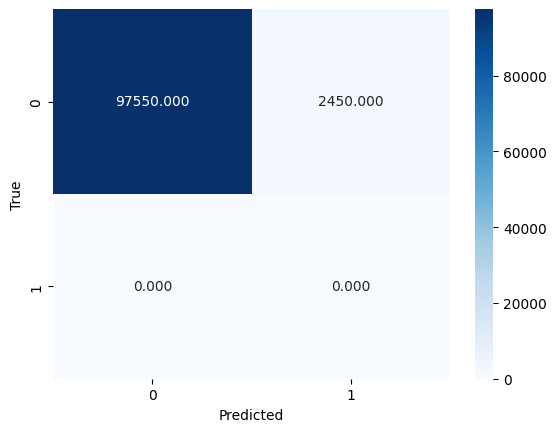

In [67]:
# Comparing predictions with ground truth according to Wazuh (level > 0 is anomaly)
foo(model, val_loader2, (400000, 500000))

In [68]:
model.save(os.path.join(ROOT_DIR, "models", "deeplog", "deeplog_0_2.pt"))

In [69]:
model = load_model(os.path.join(ROOT_DIR, "models", "deeplog", "deeplog_0_2.pt"), device)

In [70]:
vals, indices = torch.topk(torch.tensor(foo_loss), 20)
vals

tensor([0.4737, 0.4565, 0.4518, 0.4494, 0.4477, 0.4404, 0.4381, 0.4381, 0.4359,
        0.4359, 0.4344, 0.4322, 0.4283, 0.4283, 0.4258, 0.4255, 0.4241, 0.4231,
        0.4228, 0.4224], dtype=torch.float64)

In [73]:
[i for i in df_sorted[400000:500000].iloc[indices]["URL"]]

['/plantilles/turisme/eltemps/wstemps.php?site=1&lang=es HTTP/2.0',
 '/plantilles/turisme/css/font/Brushways.woff HTTP/2.0',
 '/plantilles/turisme/css/font/Brushways.woff HTTP/2.0',
 '/plantilles/turisme/css/font/Brushways.woff HTTP/2.0',
 '/comu/flowplayer/flowplayer.min.js HTTP/2.0',
 '/plantilles/turisme/css/font/Brushways.woff HTTP/2.0',
 '/plantilles/turisme/css/font/Intro-Black-Alt.woff2 HTTP/2.0',
 '/plantilles/turisme/css/font/Intro-Black-Alt.woff2 HTTP/2.0',
 '/plantilles/turisme/css/font/Brushways.woff HTTP/2.0',
 '/plantilles/turisme/css/font/Brushways.woff HTTP/2.0',
 '/comu/js/cookiemanager.js HTTP/2.0',
 '/plantilles/turisme/css/font/Brushways.woff HTTP/2.0',
 '/plantilles/turisme/css/font/Brushways.woff HTTP/2.0',
 '/comu/js/lib.js?v=3 HTTP/2.0',
 '/plantilles/turisme/css/font/Intro-Black-Caps.woff2 HTTP/2.0',
 '/plantilles/turisme/css/bg-video.css HTTP/2.0',
 '/comu/js/jquery-ui-1.13.1/jquery-ui.min.js HTTP/2.0',
 '/comu/flowplayer/skin/skin.css HTTP/2.0',
 '/plantilles